In [1]:
from cause_ml.examples.genmatch import GenmatchDataGeneratingProcess, GENMATCH_SPECS
from cause_ml.examples.genmatch import LogisticPropensityMatchingCausalModel
from cause_ml.data_analysis import calculate_data_axis_metrics, gather_axis_metrics_for_given_params
from cause_ml.constants import Constants
import cause_ml.data_sources as data_sources
from cause_ml.parameters import build_parameters_from_axis_levels
from cause_ml.benchmarking import run_sampled_dgp_benchmark, run_concrete_dgp_benchmark
from cause_ml.data_sources import DataSource
from cause_ml.data_generation import SampledDataGeneratingProcess, data_generating_method

In [2]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Define axes and metrics to analyze
axes_and_metrics = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

In [4]:
G_param_overrides = {
  "TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7, #
        "POLY_QUAD": 0.3, #0.3
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0.11, #0.11
        "INTERACTION_THREE_WAY": 0,
  },
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = {
  "TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0.0,
        "INTERACTION_THREE_WAY": 0,
  },
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

C_param_overrides = {
  "TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0.3,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0.0,
        "INTERACTION_THREE_WAY": 0,
  },
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}


In [5]:
def generate_genmatch_covars():
    n_covars = 11
    n_observations = 1000
    binary_cols = [1, 3, 5, 6, 8, 9]
    
    X = np.random.normal(loc=0.0, scale=1.0, size=(
            n_observations, n_covars-1))
    
    # Add bias/intercept dummy column
    X = np.hstack([np.ones((n_observations, 1)), X])
    
    # Make binary columns binary.
    for var in binary_cols:
        X[:, var-1] = (X[:, var -1] > 0).astype(int)
    
    # Name sequentially
    covar_names = np.array([f"X{i}" for i in range(n_covars)])

    # Build DF
    norm_covars = pd.DataFrame(X, columns=covar_names)
    
    return DataSource(
        covariate_data=norm_covars,
        binary_column_names=list(covar_names[binary_cols]) + ["X0"])

## Param Validation

In [4]:
genmatch_dgp = GenmatchDataGeneratingProcess(
        *GENMATCH_SPECS["G"],
        n_observations=1000, analysis_mode=True)

n_genmatch_samples = 100

# TODO: it should be possible to get metric vals from multiple draws from a DGP
# and also to get metric vals from a parameterization of a DGP sampler.
# This code can then be replaced.
genmatch_metric_vals = defaultdict(lambda: defaultdict(list))
for _ in range(n_genmatch_samples):
    genmatch_dataset = genmatch_dgp.generate_dataset()
#     print(genmatch_dgp.base_outcome_expression)
    metrics = calculate_data_axis_metrics(genmatch_dataset, axes_and_metrics)
    
    for metric, measures in axes_and_metrics.items():
        for measure in measures:
            res = metrics[metric][measure]
            if res is not None:
                genmatch_metric_vals[metric][measure].append(res)

In [41]:
%%time

n_mc_samples = 25

dgp_params = build_parameters_from_axis_levels({
    Constants.AxisNames.TREATMENT_NONLINEARITY: Constants.AxisLevels.HIGH,
    Constants.AxisNames.OUTCOME_NONLINEARITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.TE_HETEROGENEITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.ALIGNMENT: Constants.AxisLevels.LOW
})

for param_name in param_overrides:
    dgp_params.set_parameter(param_name, param_overrides[param_name])

mc_metric_vals = gather_axis_metrics_for_given_params(
    dgp_params, axes_and_metrics, generate_genmatch_covars, n_trials=n_mc_samples)

CPU times: user 28.8 s, sys: 14.4 s, total: 43.2 s
Wall time: 19.9 s


In [42]:
for axes, metrics in axes_and_metrics.items():
    print(axes)
    for metric in metrics:
        print("\t", metric)
        print("\t\tGenmatch:", np.round(np.mean(genmatch_metric_vals[axes][metric]), 3))
        print("\t\tMC:", np.round(np.mean(mc_metric_vals[axes][metric]), 3))

OUTCOME_NONLINEARITY
	 Lin r2(X_obs, Y)
		Genmatch: 0.972
		MC: 0.889
	 Lin r2(X_true, Y)
		Genmatch: 0.973
		MC: 0.892
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
		Genmatch: 0.872
		MC: 0.774
PERCENT_TREATED
	 Percent(T==1)
		Genmatch: 42.143
		MC: 49.664
BALANCE
	 Wass dist X_true: T=1<->T=0
		Genmatch: 0.049
		MC: 0.045
ALIGNMENT
	 Lin r2(Y, Treat Logit)
		Genmatch: 0.062
		MC: 0.117
	 Lin r2(Y0, Treat Logit)
		Genmatch: 0.021
		MC: 0.12
TE_HETEROGENEITY
	 std(TE)/std(Y)
		Genmatch: 0.0
		MC: 0.0


## Benchmarks

At config A, 20-50 matches across runs. Wide distro. Should investigate the stability of the concrete distro when n=1000.

At config G, 20-50 has much lower bias in the sampled benchmark. The concrete function appears to be a worst case scenario given that very similar functions experience much lower typical bias. The distribution is right tailed and so it is possible that the concrete func chosen is just an (un)lucky sample from right tail.

I will test this by permuting the variable order in the exact same functional form.

### Genmatch Concrete Benchmark

In [31]:
%%time

# Concrete Benchmark
dgp = GenmatchDataGeneratingProcess(
    *GENMATCH_SPECS["C"],
    n_observations=1000, analysis_mode=False)

genmatch_results = defaultdict(list)
for _ in range(1):
    genmatch_result = run_concrete_dgp_benchmark(
        dgp=dgp,
        model_class=LogisticPropensityMatchingCausalModel,
        estimand=Constants.Model.ATE_ESTIMAND,
        num_samples_from_dgp=1000,
        enable_ray_multiprocessing=False)
    
    for metric, res in genmatch_result.items():
        genmatch_results[metric].append(res)

CPU times: user 6min 9s, sys: 6min 24s, total: 12min 34s
Wall time: 2min 15s


In [32]:
for metric, results in genmatch_results.items():
    print(metric, np.round(np.mean(results), 3))
    print(metric + " std", np.round(np.std(results), 3))

absolute mean bias % 0.271
absolute mean bias % std 0.0
root mean squared error 0.093
root mean squared error std 0.0


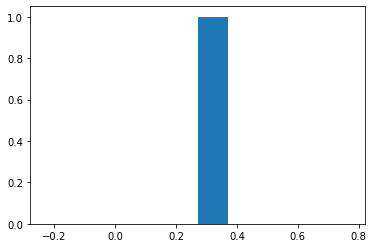

In [33]:
plt.hist(genmatch_results["absolute mean bias %"])
plt.show()

### Sampled Benchmark

In [6]:
class NoiselessSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    
    @data_generating_method(Constants.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0

In [20]:
%%time

param_grid = {
    Constants.AxisNames.TREATMENT_NONLINEARITY: [Constants.AxisLevels.LOW],
    Constants.AxisNames.OUTCOME_NONLINEARITY: [Constants.AxisLevels.LOW],
    Constants.AxisNames.TE_HETEROGENEITY: [Constants.AxisLevels.LOW],
    Constants.AxisNames.ALIGNMENT: [Constants.AxisLevels.LOW]
}

# covar_data_source = lambda: data_sources.load_random_normal_covariates(
#     n_covars=10,
#     n_observations=1000)

covar_data_source = generate_genmatch_covars

param_overrides = C_param_overrides

mc_result, all_results = run_sampled_dgp_benchmark(
    dgp_class=NoiselessSampledDataGeneratingProcess,
    model_class=LogisticPropensityMatchingCausalModel,
    estimand=Constants.Model.ATE_ESTIMAND,
    data_source_generator=covar_data_source,
    param_grid=param_grid,
    num_dgp_samples=20,
    num_data_samples_per_dgp=40,
    param_overrides=param_overrides,
    dgp_kwargs={"analysis_mode": False},
    enable_ray_multiprocessing=False)

CPU times: user 4min 19s, sys: 4min 30s, total: 8min 49s
Wall time: 1min 31s


In [21]:
pd.DataFrame(mc_result)

,param_alignment,param_outcome_nonlinearity,param_te_heterogeneity,param_treatment_nonlinearity,absolute mean bias %,absolute mean bias % (std),root mean squared error,root mean squared error (std)
0,LOW,LOW,LOW,LOW,6.634127,13.68467,0.059181,0.011146


In [22]:
all_results["absolute mean bias %"]

[0.4445964896003985,
 54.29301475244822,
 1.2492883808130917,
 4.296738932074327,
 0.5177871933822251,
 0.5126678504497362,
 18.034883499682156,
 8.044786334840238,
 0.5464672082046652,
 0.3741999111166333,
 1.0114205585439402,
 1.5607651923611277,
 0.6327931609262369,
 0.8479102126423043,
 0.5793529710925611,
 0.5608157991849627,
 2.245054490887245,
 35.41669041344453,
 0.05527805597174771,
 1.4580334625524736]

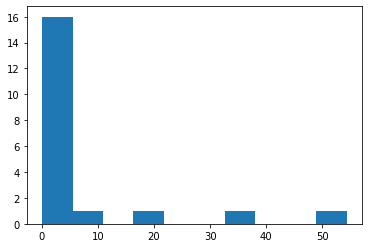

In [23]:
plt.hist(all_results["absolute mean bias %"])
plt.show()

In [24]:
index = 0
print(all_results["absolute mean bias %"][index])
all_results["eqn"][index]

0.4445964896003985


Max(-2.19722457733622, Min(2.19722457733622, -0.673276852805541*X1 + 0.0886843166329879*X10**2 - 0.157459909123876*X10 + 0.184608169317648*X2 - 0.300440746144408*X3 - 0.0416273322971168*X4 - 0.0217186081550174*X5 + 0.15384014109804*X7**2 - 0.115572809911108))